# AMAZON CHRONOS

SMAPE на тестовом периоде: 132.227840588909 %


/var/folders/bp/w9_t0wtj46q0klpjxcsg8knw0000gn/T/ipykernel_3620/3894789188.py:79: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  y_pred = np.array(y_pred)


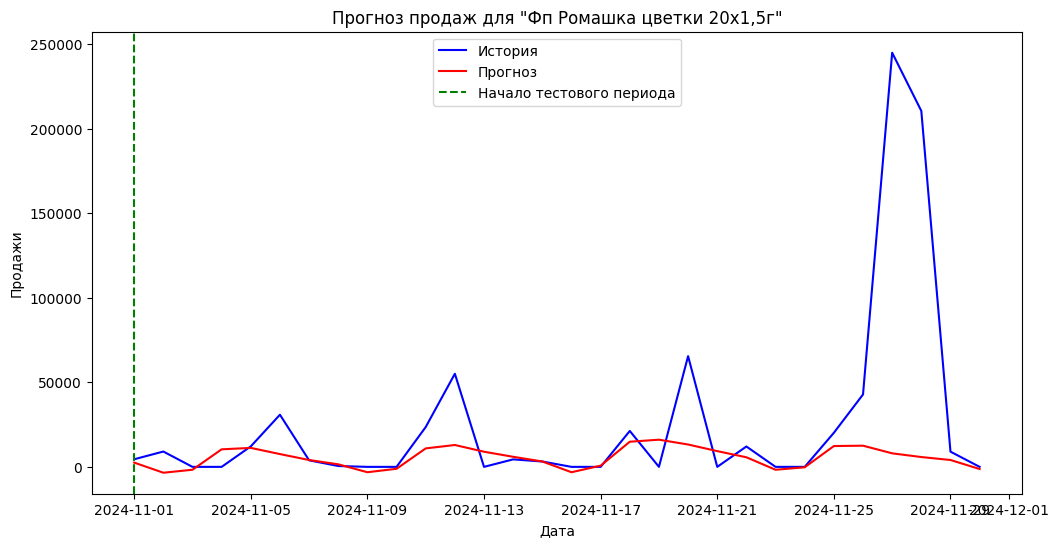

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import torch
import numpy as np

from chronos import BaseChronosPipeline


# Шаг 1: Загрузка данных
df = pd.read_excel('data/sales.xlsx')
df.columns = ['date', 'item', 'sales']
df['date'] = pd.to_datetime(df['date'])

# Фильтрация по нужной номенклатуре
item_name = "Фп Ромашка цветки 20x1,5г"
df_item = df[df['item'] == item_name].copy().sort_values('date')

# Создаём полный список дат от минимальной до максимальной
full_dates = pd.date_range(start=df_item['date'].min(), end=df_item['date'].max(), freq='D')
df_full = pd.DataFrame({'date': full_dates})
df_full = df_full.merge(df_item[['date', 'sales']], on='date', how='left')
df_full['sales'] = df_full['sales'].fillna(0)

# Переименуем колонки под формат ds/y
df_full = df_full.rename(columns={'date': 'ds', 'sales': 'y'})

# Определяем тренировочный и тестовый периоды
train_end = pd.to_datetime("2024-10-31")
test_start = pd.to_datetime("2024-11-01")
test_end = pd.to_datetime("2024-11-30")

df_train = df_full[df_full['ds'] <= train_end]
df_test = df_full[(df_full['ds'] >= test_start) & (df_full['ds'] <= test_end)]

# Шаг 2: Инициализация предварительно обученного пайплайна
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-bolt-base",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

# В зависимости от документации, pipeline может ожидать метод для предсказания.
# Предположим, что pipeline имеет метод predict, принимающий датафрейм с историей
# и аргумент horizon для количества точек в будущем, которые нужно предсказать.
# У нас тестовый период — это ноябрь 2024 года (30 дней).

horizon = 30

# Предполагаем, что pipeline может сам определить конец историй и сделать прогноз на следующие horizon дней.
# Если необходимо, можно отсечь тренировочные данные:
historical_df = df_train.copy()

# Предсказание
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(historical_df['y']),
    prediction_length=horizon,
    quantile_levels=[0.1, 0.5, 0.9],
)
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

# Теперь pred_df должен содержать прогнозы на следующие 30 дней после train_end.
# Сравним с фактическими данными за test_period:
y_true = df_test['y'].values
y_pred = median  # предположим, что колонка прогноза называется yhat

def smape(y_true, y_pred):
    """
    Расчет Symmetric Mean Absolute Percentage Error (SMAPE).

    Параметры:
    y_true : array-like, истинные значения
    y_pred : array-like, предсказанные значения

    Возвращает:
    float : значение SMAPE в процентах
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff = diff[np.isfinite(diff)]  # исключаем случаи, где denominator = 0
    return np.mean(diff) * 100

score = smape(y_true, y_pred)
print("SMAPE на тестовом периоде:", score, "%")

# Визуализируем результат
plt.figure(figsize=(12,6))
plt.plot(df_test['ds'], df_full[(df_full['ds'] >= test_start) & (df_full['ds'] <= test_end)]['y'], label='История', color='blue')
plt.plot(df_test['ds'],y_pred, label='Прогноз', color='red')
plt.axvline(x=test_start, color='green', linestyle='--', label='Начало тестового периода')
plt.title(f'Прогноз продаж для "{item_name}"')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.show()

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.663% of the data.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (19) is too small than the required number                     for the learning rate finder (214). The results might not be optimal.


Finding best initial lr:   0%|          | 0/214 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 96.667% of the data.
WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is depreca

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


MAE на тестовом периоде: 40195.76125488281
MAPE на тестовом периоде: 411.9451879716059 %
MASE на тестовом периоде: 1.6272577082347321


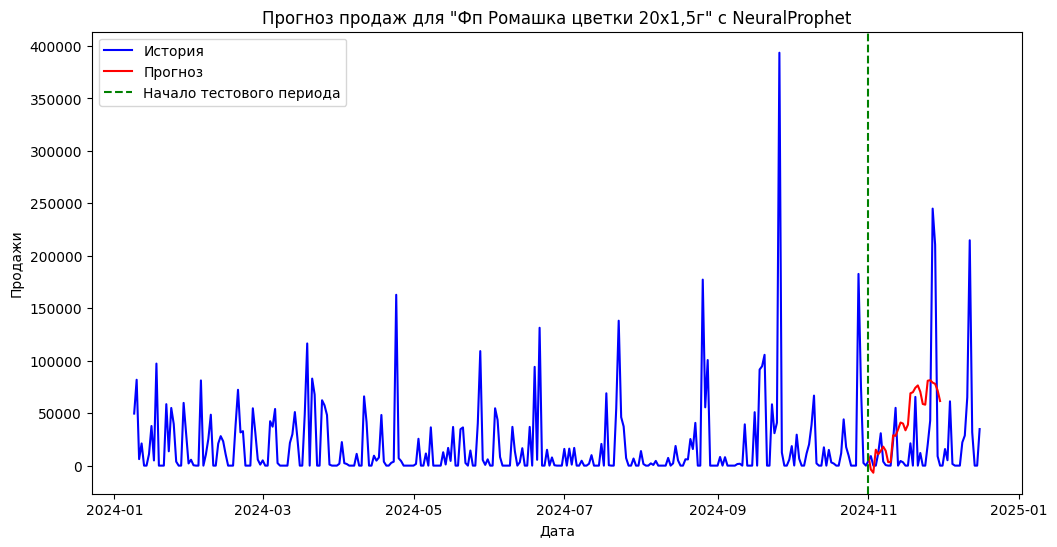

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet

def MAE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.nan

def MASE(y_true, y_pred, y_train):
    # MASE = MAE(y_test,y_pred) / MAE(y_train[1:], y_train[:-1]) (наивный прогноз)
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae_forecast = np.mean(np.abs(y_true - y_pred))

    # Наивная ошибка на train
    if len(y_train) < 2:
        return np.nan
    mae_naive = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    return mae_forecast / mae_naive if mae_naive != 0 else np.nan

# Шаг 1: Загрузка данных
df = pd.read_excel('data/sales.xlsx')
df.columns = ['ds', 'item', 'y']
df['ds'] = pd.to_datetime(df['ds'])

item_name = "Фп Ромашка цветки 20x1,5г"
df_item = df[df['item'] == item_name].copy().sort_values('ds')

# Формируем непрерывный временной ряд
full_dates = pd.date_range(start=df_item['ds'].min(), end=df_item['ds'].max(), freq='D')
df_full = pd.DataFrame({'ds': full_dates})
df_full = df_full.merge(df_item[['ds', 'y']], on='ds', how='left')
df_full['y'] = df_full['y'].fillna(0)

# Доп. признаки
df_full['day_of_month'] = df_full['ds'].dt.day
df_full['end_of_month'] = (df_full['day_of_month'] > 25).astype(int)
df_full['day_of_week'] = df_full['ds'].dt.dayofweek
df_full['is_weekend'] = (df_full['day_of_week'] >= 5).astype(int)
df_full['sin_day_of_month'] = np.sin(2 * np.pi * df_full['day_of_month'] / 31)
df_full['cos_day_of_month'] = np.cos(2 * np.pi * df_full['day_of_month'] / 31)

train_end = pd.to_datetime("2024-10-31")
test_start = pd.to_datetime("2024-11-01")
test_end = pd.to_datetime("2024-11-30")

df_train = df_full[df_full['ds'] <= train_end]
df_test = df_full[(df_full['ds'] >= test_start) & (df_full['ds'] <= test_end)]

# NeuralProphet модель
m = NeuralProphet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
m = m.add_seasonality(name='monthly', period=30, fourier_order=5)

# Добавим все регрессоры
regressors = ['day_of_month', 'end_of_month', 'day_of_week', 'is_weekend',
              'sin_day_of_month', 'cos_day_of_month']
for r in regressors:
    m = m.add_future_regressor(name=r)

# Обучение
m.fit(df_train[['ds','y'] + regressors], freq='D')

# Для прогноза на тестовом периоде создадим future_df
df_future = df_test.copy()
# Прогнозные значения y пока неизвестны, пусть будут NaN
df_future['y'] = np.nan

# Прогноз
forecast = m.predict(df_future[['ds','y'] + regressors])

# Извлекаем предсказания
forecast_test = forecast.set_index('ds').loc[test_start:test_end]
y_pred = forecast_test['yhat1'].values  # NeuralProphet в последней версии имя прогнозной колонки yhat или yhat1

y_true = df_test['y'].values
y_train = df_train['y'].values

mae_score = MAE(y_true, y_pred)
mape_score = MAPE(y_true, y_pred)
mase_score = MASE(y_true, y_pred, y_train)

print("MAE на тестовом периоде:", mae_score)
print("MAPE на тестовом периоде:", mape_score, "%")
print("MASE на тестовом периоде:", mase_score)

# Визуализация
plt.figure(figsize=(12,6))
plt.plot(df_full['ds'], df_full['y'], label='История', color='blue')
plt.plot(df_test['ds'], y_pred, label='Прогноз', color='red')
plt.axvline(x=test_start, color='green', linestyle='--', label='Начало тестового периода')
plt.title(f'Прогноз продаж для \"{item_name}\" с NeuralProphet')
plt.xlabel('Дата')
plt.ylabel('Продажи')
plt.legend()
plt.show()